In [ ]:
# импорт необходимых библиотек
import numpy as np
import pandas as pd
import sklearn
from sklearn.datasets import load_breast_cancer, load_digits
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import accuracy_score, brier_score_loss, hinge_loss, log_loss
from sklearn.multiclass import (
    OneVsRestClassifier,
    OneVsOneClassifier,
    OutputCodeClassifier,
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC

import warnings

# игнорирование предупреждений для большей наглядности
warnings.filterwarnings("ignore")

# Исследование методов линейной классификации

## Указания

- Заполните все ячейки кода и ответьте на вопросы, указанные в тексте
- Во всех заданиях используйте `random_state=42`

## Часть 1: Бинарная классификация

Мы будем использовать набор данных о раке молочной железы (breast cancer dataset) из sklearn. Для всех моделей здесь нормализуйте признаки перед подачей их в модель. Для этого используйте [StandardScaler](https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.StandardScaler.html)

In [240]:
# загрузка данных из breast_cancer
data = load_breast_cancer()
X, y = data.data, data.target

In [241]:
# разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [242]:
print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (455, 30)
Размер тестовой выборки: (114, 30)


**Задание 1:** Стандартизируйте данные через [StandardScaler](https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.StandardScaler.html)

In [243]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Исследование различных функций потерь

**Задание 2:**  Используйте [SGDClassifier](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.SGDClassifier.html) (с `random_state=42`!) для реализации линейных классификаторов с различными функциями потерь:
- 'hinge'
- 'log_loss'
- 'perceptron'
- 'modified_huber'

Выведите значение Accuracy для каждой из функций потерь. Можете отобразить его на графике с помощью `plt.bar`

0.9649122807017544
0.9298245614035088
0.9736842105263158
0.956140350877193


<BarContainer object of 4 artists>

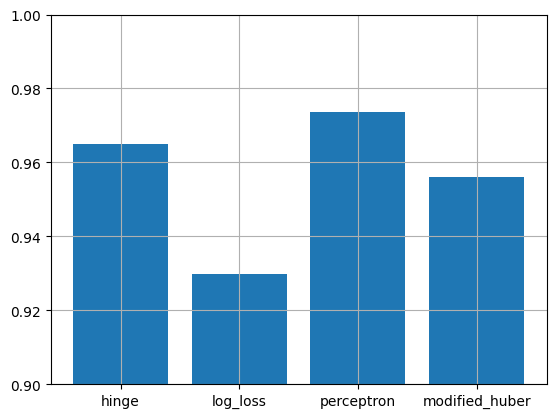

In [244]:
model_hinge = SGDClassifier(loss="hinge", random_state=42)
model_log_loss = SGDClassifier(loss="log_loss", random_state=42)
model_perceptron = SGDClassifier(loss="perceptron", random_state=42)
model_modified_huber = SGDClassifier(loss="modified_huber", random_state=42)

model_list = [
    model_hinge,
    model_log_loss,
    model_perceptron,
    model_modified_huber,
]
accuracy_res_list = []
for model in model_list:
    model.fit(X_train, y_train)
    accuracy = accuracy_score(y_test, model.predict(X_test))
    accuracy_res_list.append(accuracy)
    print(accuracy)


plt.ylim(0.90, 1.0)
plt.grid()
plt.bar(
    x=["hinge", "log_loss", "perceptron", "modified_huber"], height=accuracy_res_list
)

# --------------

**Задание 3:**  Для модели с лучшим лоссом постройте confusion matrix

In [245]:
def show_conf_matrix(Y_test, Y_hat):
    cm = sklearn.metrics.confusion_matrix(
        Y_test, Y_hat
    )  # матрица счётчиков true_class x predicted_class
    disp = sklearn.metrics.ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=model.classes_
    )
    disp.plot()

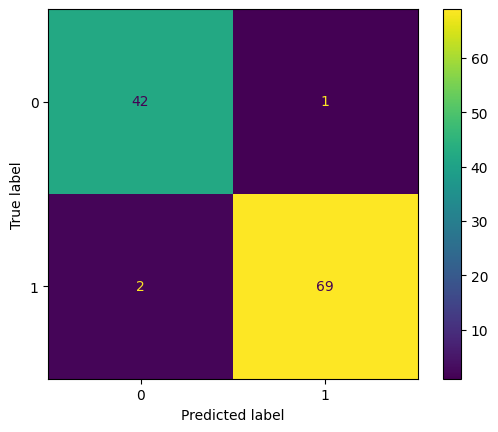

In [246]:
show_conf_matrix(y_test, model_perceptron.predict(X_test))

### Прогноз вероятностей классов

**Задание 4:**  Для логистической регрессии рассчитайте вероятности классов и меру Бриера.
Для выполнения можете использовать `sklearn.metrics.brier_score_loss`

In [247]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_proba = logreg.predict_proba(X_test)
brier_score = brier_score_loss(y_test, y_pred_proba[:, 1])
print(f"Brier Score: {brier_score}")

Brier Score: 0.016703093965177336


# --------------

### Варьирование гиперпараметров

**Задание 5:**  Изучите воздействие `alpha`, `eta_0` и вида регуляризации (L1 или L2) на качество модели для log_loss. 
Выведите значения параметров и Accuracy для лучшей модели

Параметры в следующей ячейке

In [248]:
alphas = np.logspace(-4, 0, 5)
learning_rates = np.logspace(-4, 0, 5)
penalties = ["l1", "l2"]

In [249]:
param_grid = {
    "alpha": np.logspace(-4, 0, 5),
    "eta0": np.logspace(-4, 0, 5),
    "penalty": ["l1", "l2"],
}
logreg = SGDClassifier(loss="log_loss", random_state=42)

searcher = GridSearchCV(logreg, param_grid=param_grid, cv=5, n_jobs=-1)

In [250]:
searcher.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SGDClassifier(loss='log_loss', random_state=42),
             n_jobs=-1,
             param_grid={'alpha': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]),
                         'eta0': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]),
                         'penalty': ['l1', 'l2']})

In [251]:
searcher.best_params_

{'alpha': 0.01, 'eta0': 0.0001, 'penalty': 'l2'}

In [252]:
print(f"Accuracy: {accuracy_score(y_test, searcher.predict(X_test))}")

Accuracy: 0.9824561403508771


# --------------

**Задание 6:** Для `sklearn.svm.LinearSVC`, проварьируйте параметры и выведите оптимальные значения и Accuracy

In [253]:
params = {
    "loss": ["hinge", "squared_hinge"],
    "penalty": ["l2"],
    "C": [0.01, 0.1, 1, 10],
    "multi_class": ["ovr", "crammer_singer"],
    "max_iter": [100000],
}

In [254]:
linear_svc = LinearSVC(random_state=42)

searcher_linear_svc = GridSearchCV(linear_svc, param_grid=params, cv=5, n_jobs=-1)

In [255]:
searcher_linear_svc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LinearSVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'loss': ['hinge', 'squared_hinge'],
                         'max_iter': [100000],
                         'multi_class': ['ovr', 'crammer_singer'],
                         'penalty': ['l2']})

In [256]:
best_params_linear_svc = searcher_linear_svc.best_params_

In [257]:
print(
    f"Best params: {best_params_linear_svc}\nAccuracy: {accuracy_score(y_test, searcher_linear_svc.predict(X_test))}"
)

Best params: {'C': 0.01, 'loss': 'hinge', 'max_iter': 100000, 'multi_class': 'crammer_singer', 'penalty': 'l2'}
Accuracy: 0.9824561403508771


# --------------

**Задание 7:** Сравните время обучения для dual=True и dual=False. 

Запустите модель с dual=True и dual=False с лучшими параметрами из предыдущего пункта. Сравните время обучения и объясните результаты.


In [258]:
%time
linear_svc_dual = LinearSVC(dual=True,random_state=42,  **best_params_linear_svc)
linear_svc_dual.fit(X_train, y_train)

CPU times: user 1 μs, sys: 0 ns, total: 1 μs
Wall time: 3.1 μs


LinearSVC(C=0.01, dual=True, loss='hinge', max_iter=100000,
          multi_class='crammer_singer', random_state=42)

In [259]:
%time
linear_svc_wo_dual = LinearSVC(dual=False, random_state=42, **best_params_linear_svc)
linear_svc_wo_dual.fit(X_train, y_train)


CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 4.77 μs


LinearSVC(C=0.01, dual=False, loss='hinge', max_iter=100000,
          multi_class='crammer_singer', random_state=42)

#### Разница во времени обучения в 1мс, без обучения двойственной задачи обучется быстрее в виду того, что использование Dual=False может быть быстрее, так как он может использовать меньше памяти.

# --------------

## Часть 2: Многоклассовая классификация

Используем набор данных `digits`.

In [260]:
# загрузка данных digits
digits = load_digits()
X, y = digits.data, digits.target

# разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

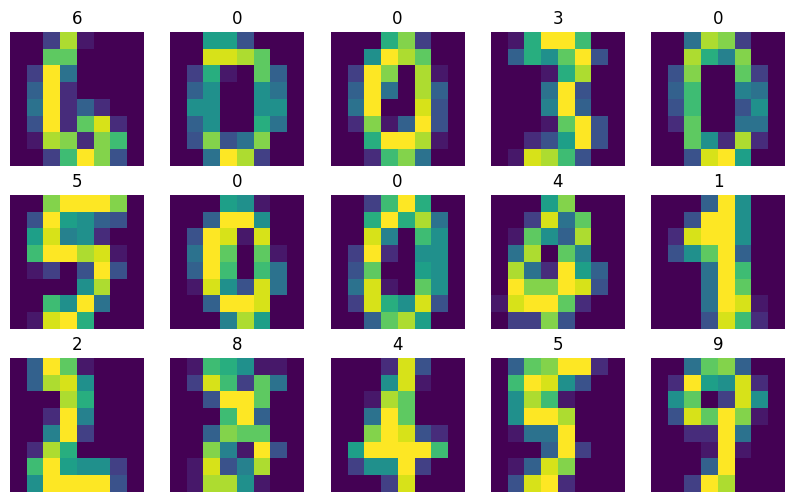

In [261]:
# Изображение элементов
f, ax = plt.subplots(3, 5, figsize=(10, 6))
for i in range(3):
    for j in range(5):
        ax[i][j].axis("off")
        ax[i][j].set_title(y_train[5 * i + j])
        ax[i][j].imshow(X_train[i * 5 + j].reshape(8, 8))

### Методы для многоклассовой классификации

**Задание 8:**  Реализуйте стратегию one-vs-all и one-vs-one, а также метод error correction codes c дефолтными параметрами (и c `random_state=42`) `SGDClassifier`.

Используйте классы `OneVsRestClassifier`, `OneVsOneClassifier` и `OutputCodeClassifier`

In [262]:
OVR = OneVsRestClassifier(estimator=SGDClassifier(random_state=42))
OVO = OneVsOneClassifier(estimator=SGDClassifier(random_state=42))
OutputCode = OutputCodeClassifier(estimator=SGDClassifier(random_state=42))

In [263]:
OVR.fit(X_train, y_train)
preds_OVR = OVR.predict(X_test)
accuracy_score(y_test, preds_OVR)

0.95

In [264]:
OVO.fit(X_train, y_train)
preds_OVO = OVO.predict(X_test)
accuracy_score(y_test, preds_OVO)

0.9583333333333334

In [265]:
OutputCode.fit(X_train, y_train)
preds_OutputCode = OutputCode.predict(X_test)
accuracy_score(y_test, preds_OutputCode)

0.9166666666666666

# --------------

**Задание 9:** Изобразите confusion matrix для One-vs-One подхода

Text(0.5, 1.0, 'Confusion matrix:')

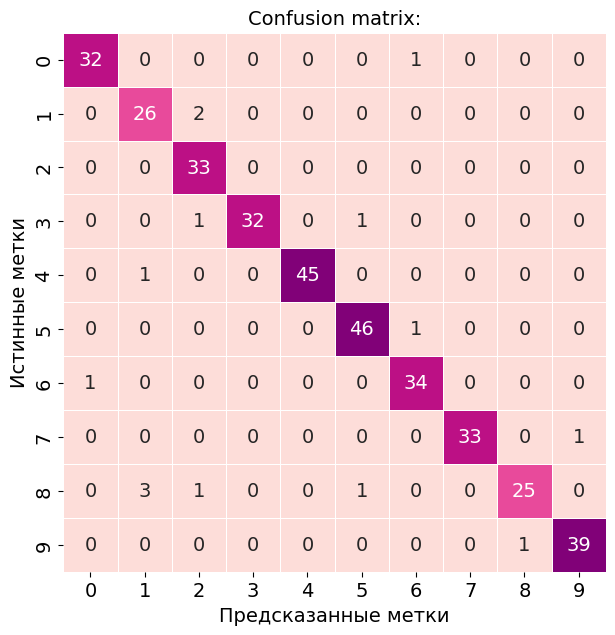

In [266]:
import seaborn as sns

labels = [i for i in range(10)]
conf_matrix = sklearn.metrics.confusion_matrix(y_test, preds_OVO, labels=labels)
# plot heatmap
_, ax = plt.subplots(1, 1, figsize=(7, 7))
cmap = sns.color_palette("RdPu")

fontsize = 14
ax = sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    xticklabels=labels,
    yticklabels=labels,
    cmap=cmap,
    linewidths=0.5,
    annot_kws={"size": fontsize},
    linecolor="white",
    cbar=False,
)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=fontsize)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)
ax.set_xlabel("Предсказанные метки", fontsize=fontsize)
ax.set_ylabel("Истинные метки", fontsize=fontsize)
ax.set_title("Confusion matrix:", fontsize=fontsize)

# --------------

**Задание 10:**  Изобразите объекты, на которых модель One-vs-One ошиблась

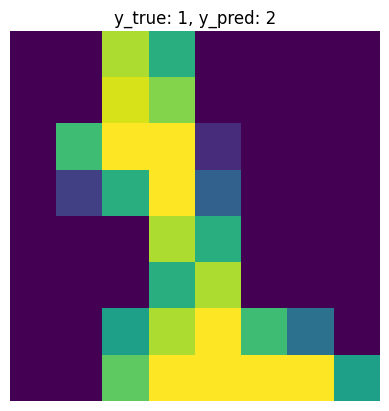

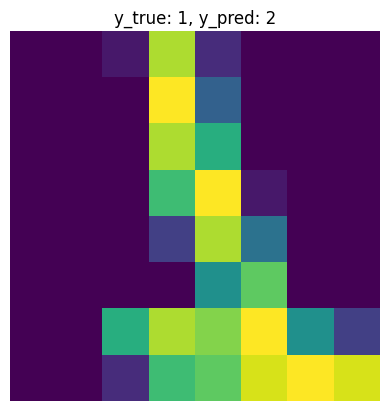

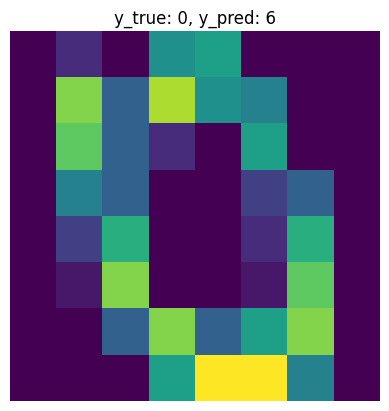

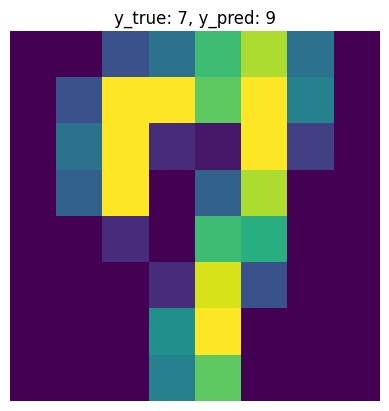

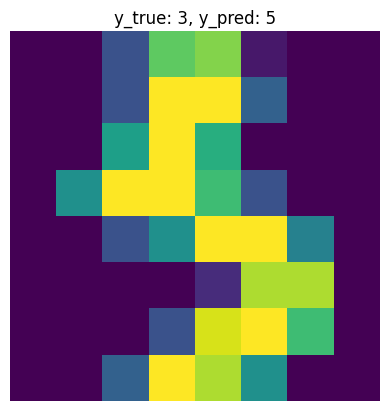

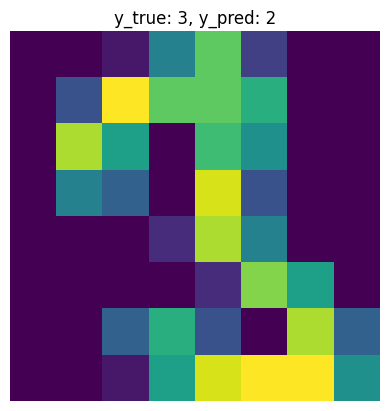

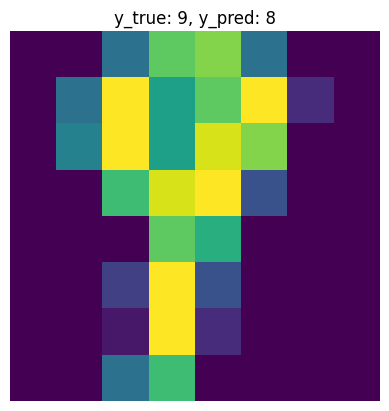

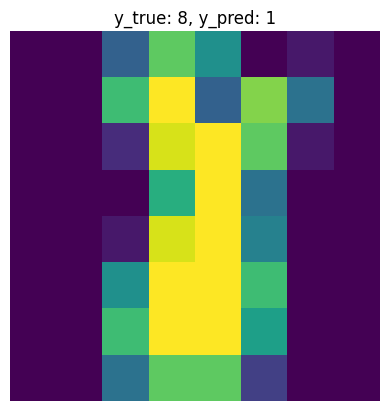

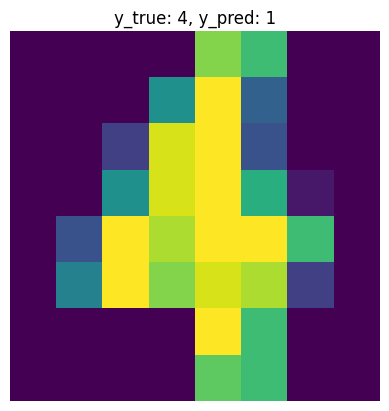

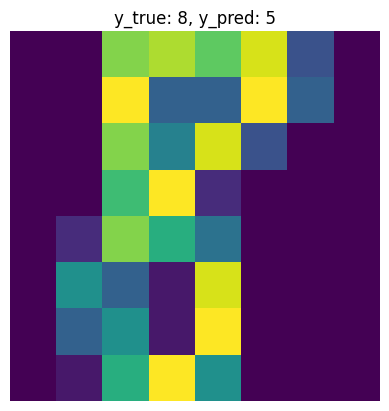

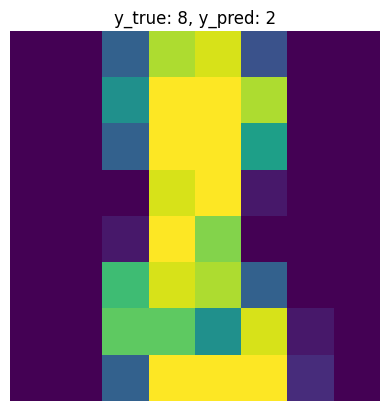

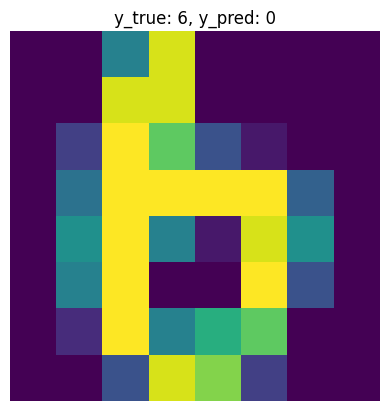

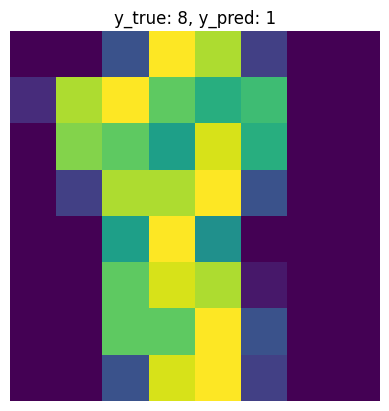

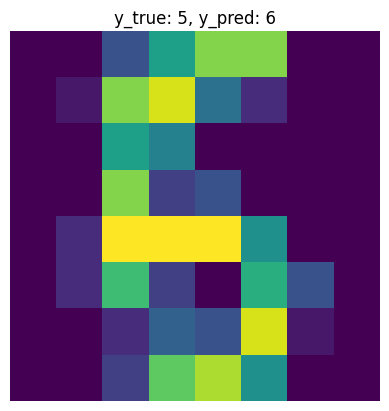

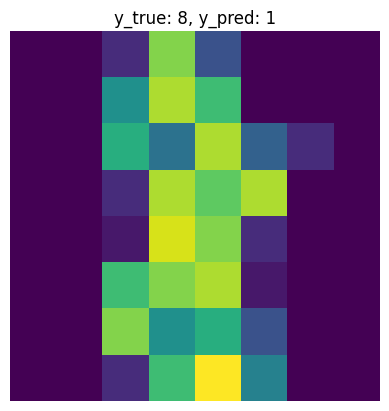

In [267]:
for object_, y_true, y_pred in zip(
    X_test[(preds_OVO != y_test)],
    y_test[(preds_OVO != y_test)],
    preds_OVO[(preds_OVO != y_test)],
):
    plt.figure()
    plt.axis("off")
    plt.title(f"y_true: {y_true}, y_pred: {y_pred}")
    plt.imshow(object_.reshape(8, 8))

# --------------

### Настройка параметров для методов многоклассовой классификации

**Задание 11:**  Постройте график зависимости качества модели от силы регуляризации

Для `SGDClassifier`  c дефолтными параметрами (и c `random_state=42`) проварьируйте альфа в диапазоне `np.logspace(-7, 1, 20)` и приведите график Accuracy в зависимости от альфа. Объясните, с чем связана форма полученного графика.

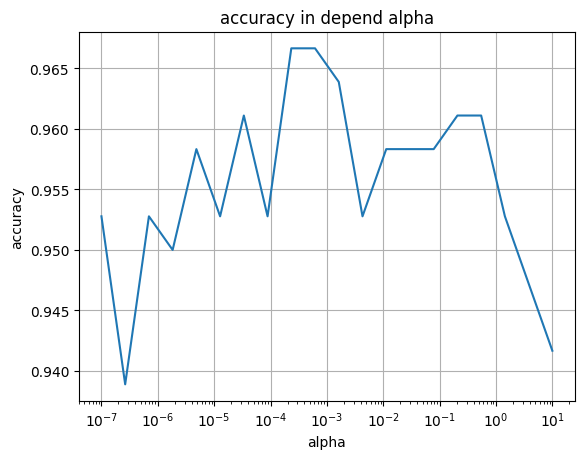

In [269]:
accuracy_score_list = []
alpha_list = np.logspace(-7, 1, 20)
for alpha in alpha_list:
    clf = SGDClassifier(alpha=alpha, random_state=42)
    clf.fit(X_train, y_train)
    accuracy_score_list.append(accuracy_score(y_test, clf.predict(X_test)))

plt.grid()
plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.title("accuracy in depend alpha")
plt.xscale("log")
plt.plot(alpha_list, accuracy_score_list)

#### alpha отвечает за силу регуляризации, при слишком низком значении точность мала, тк влияние регуляризации небольшое, при слишком высоком значении точность мала, тк влияние регуляризации слишком большое и модель переобучается. Лучшее значение находится в порядке 10^-3 - 10^-4.

# --------------

**Задание 12:**  Проанализируйте сходимость для разных значений eta0 с `learning_rate='constant'`. Для `SGDClassifier` с `random_state=42` постройте график лосса для различных значений eta0 в зависимости от количества итераций. 

Для частичного обучения используйте параметры `learning_rate='constant'` и `warm_start=True`

Используйте значения eta0 из ячейки ниже. 


In [ ]:
# Проанализируйте сходимость для разных значений eta0 с learning_rate='constant'.

eta0_values = [0.00001, 0.0001, 0.1]

In [329]:
max_iter_values = [i for i in map(int, np.linspace(1, 100, 20))]

In [344]:
result = dict()
for eta0 in eta0_values:
    losses = []
    for max_iter in max_iter_values:
        clf = SGDClassifier(
            loss="log_loss",
            eta0=eta0,
            max_iter=max_iter,
            learning_rate="constant",
            warm_start=True,
            random_state=42,
        )
        clf.fit(X_train, y_train)
        p = clf.decision_function(X_test)
        prob = np.exp(p) / np.sum(np.exp(p), axis=1, keepdims=True)
        prob = pd.DataFrame(prob).fillna(0)
        losses.append(log_loss(y_test, prob))
    result[eta0] = losses

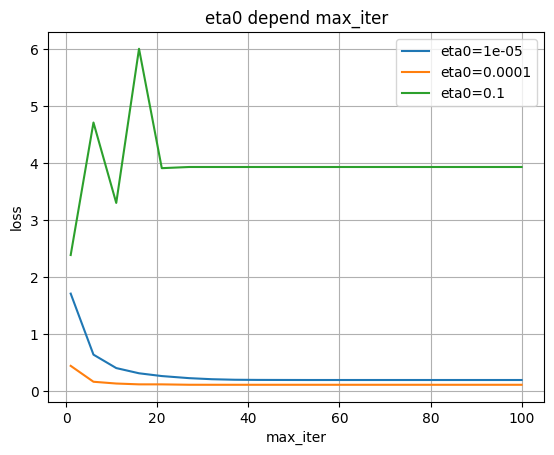

In [351]:
for eta0, losses in result.items():
    plt.plot(max_iter_values, losses)
plt.legend([f"eta0={eta0}" for eta0 in result.keys()])
plt.xlabel("max_iter")
plt.ylabel("loss")
plt.title("eta0 depend max_iter")
plt.grid()
plt.show()

####  для самого большого значения learning rate модель не может сойтись и поэтому лосс слишком большой относительно других. для слишком низкого значения learning rate модель лучше сходится, но лучшим вариантом будет eta0 = 0.0001

# --------------

**Задание 13:** Для `sklearn.svm.LinearSVC`, проварьируйте параметры и выведите оптимальные значения и Accuracy

In [216]:
params = {
    "loss": ["hinge", "squared_hinge"],
    "penalty": ["l2"],
    "C": [0.01, 0.1, 1, 10],
    "multi_class": ["ovr", "crammer_singer"],
}

In [228]:
linear_svc = LinearSVC(max_iter=1000000000, random_state=42)

searcher_linear_svc = GridSearchCV(linear_svc, param_grid=params, cv=5, n_jobs=-1)
searcher_linear_svc.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=5, estimator=LinearSVC(max_iter=1000000000, random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'loss': ['hinge', 'squared_hinge'],
                         'multi_class': ['ovr', 'crammer_singer'],
                         'penalty': ['l2']})

In [229]:
print(
    f"Best params: {best_params_linear_svc}\nAccuracy: {accuracy_score(y_test, searcher_linear_svc.predict(X_test))}"
)

Best params: {'C': 0.01, 'loss': 'hinge', 'max_iter': 100000, 'multi_class': 'crammer_singer', 'penalty': 'l2'}
Accuracy: 0.9666666666666667
